$$ y_{in} = F_{act}((Im+n_{in} W_{in}) + bias) $$
$$ Im^* = F_{act}(y_{in} W_{in}^T) + n_{out} $$

$$ Cost = \sqrt{\langle|Im-Im^*|\rangle} + \lambda \langle r \rangle $$

In [61]:
#Dependencies
import os
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr
import utils.animutils as aniu
#import utils.dirutils as diru

#code to reload
#import imp
#imp.reload(dir)

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

In [62]:
class aec_model(object):
    
    def __init__(self, params):
      params = self.add_params(params)
      self.params = params
      self.make_dirs()
      self.graph = self.make_graph()
    
    def add_params(self, params):   
        params['nneurons'] = np.int(params['imxlen']*params['imylen']/params['compression'])
        params['savefolder'] = str('./output/actfun_'+ params['model_type']+
                                   '/compression_'+ str(params['compression'])+
                                   '/noise_in_'+ str(params['noise_x'])+
                                   '_out_'+ str(params['noise_r'])+
                                   '_lambda_'+ str(params['lambd'])+'/')
        return(params)
        
    def make_dirs(self):
        if not os.path.exists(self.params['savefolder']):
            os.makedirs(self.params['savefolder'])
        
    def make_graph(self):
    
        print('Compressing by',self.params['compression'],'for a total of',self.params['nneurons'],'neurons')

        #setup our graph
        #tf.reset_default_graph()
        mygraph = tf.Graph()
        with mygraph.as_default():

            #input images
            with tf.name_scope('input'):
                self.x = tf.placeholder(tf.float32, shape=[self.params["batchsize"], 
                                                           self.params["imxlen"]*self.params["imylen"]])

            #activation function type
            with tf.name_scope('activation_function'):
                self.act_fun = self.params['model_type']

            #noises
            with tf.name_scope('noises'):
                self.noisexsigma = self.params['noise_x']
                self.noisersigma = self.params['noise_r']

            #function to add noise
            with tf.name_scope("add_noise"):
                def add_noise(input_layer, std):
                    noise = tf.random_normal(shape=tf.shape(input_layer), mean=0.0, stddev=std, dtype=tf.float32) 
                    return tf.add(input_layer,noise)

            #weights
            with tf.variable_scope("weights"):
                self.win = tf.Variable(tf.random_normal([self.params['imxlen']*self.params['imylen'],
                                                         self.params['nneurons']],
                                                        dtype=tf.float32,stddev=0.1))
                #wout = tf.Variable(tf.random_normal([nneurons,imxlen*imylen],dtype=tf.float32,stddev=0.01),name='weights_out')

            #bias
            with tf.variable_scope("bias"):
                self.bias = tf.Variable(tf.random_normal([self.params['nneurons']],dtype=tf.float32,stddev=0.1))

            #lambda
            with tf.name_scope('lambda'):
                self.lambd = self.params['lambd']

            #learning_rate
            with tf.name_scope('learning_rate'):
                self.learning_rate = self.params['learning_rate']

            #nonlienarities
            with tf.name_scope("nonlienarities"):
                #define nonlinearities
                def tanh_fun(arg):
                    return tf.nn.tanh(arg) 
                def sigmoid_fun(arg):
                    return tf.nn.sigmoid(arg) 
                def relu_fun(arg):
                    return tf.nn.relu(arg) 
                def no_fun(arg):
                    return arg

            #encoding part of model
            with tf.name_scope("encoding"):
                #calculate input
                linearin = tf.add(tf.matmul(add_noise(self.x,self.params['noise_x']),self.win),self.bias) #add noise to input, and multiply by weights
                yin = tf.case({tf.equal(self.act_fun,'tanh'): (lambda: tanh_fun(linearin)),
                               tf.equal(self.act_fun,'sigmoid'): (lambda: sigmoid_fun(linearin)),
                               tf.equal(self.act_fun,'relu'): (lambda: relu_fun(linearin))},
                              default=(lambda: no_fun(linearin)),
                              exclusive=True)
                self.yin = add_noise(yin,self.params['noise_r'])


            #output part of model
            with tf.name_scope("decoding"):
                #calculate output (reconstruction)
                linearout = tf.matmul(self.yin,tf.transpose(self.win)) #add noise to inner layer, and multiply by weight transpose
                self.xp = tf.case({tf.equal(self.act_fun,'tanh'): (lambda: tanh_fun(linearout)),
                                    tf.equal(self.act_fun,'sigmoid'): (lambda: sigmoid_fun(linearout)),
                                    tf.equal(self.act_fun,'relu'): (lambda: relu_fun(linearout))},
                                    default=(lambda: no_fun(linearout)),
                                    exclusive=True, name='output_nonlienarity')

            #calculate cost
            with tf.name_scope("cost_function"):
                self.cost = tf.sqrt(tf.reduce_mean(tf.square(self.x-self.xp))) - tf.reduce_sum(tf.abs(self.yin*self.lambd))

            #train our model
            with tf.name_scope("training_step"):
                self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)

            # create a summary for our cost, im, reconstruction, & weights
            with tf.name_scope('cost_viz'):
                tf.summary.scalar("cost", self.cost)

            with tf.name_scope('image_viz'):    
                x_t = tf.reshape(self.x,(self.params['batchsize'],self.params['imxlen'],self.params['imylen'],1))
                tf.summary.image("image", x_t, max_outputs=self.params["batchsize"])

            with tf.name_scope('recon_viz'):
                xp_t = tf.reshape(self.xp,(self.params['batchsize'],self.params['imxlen'],self.params['imylen'],1))
                tf.summary.image("recon", xp_t,max_outputs=self.params["batchsize"])

            with tf.name_scope('weights_viz'):    
                win_t = tf.reshape(tf.transpose(self.win),
                                   (self.params['nneurons'],
                                    self.params['imxlen'],
                                    self.params['imylen'],1))
                tf.summary.image("weights", win_t, max_outputs=self.params['nneurons'])

            # merge all summaries into a single "operation" which we can execute in a session 
            self.summary_op = tf.summary.merge_all()

        return(mygraph)


In [63]:
#Load in images 
def loadimages(psz):
    print("Loading Van Hateren Natural Image Database...")
    vhimgs = imr.vanHateren(
        img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
        #normalize=True,
        normalize_im = True,
        normalize_patch = False,
        invert_colors = False,
        patch_edge_size=psz
        )
    print("Done Loading!")    
    np.random.shuffle(vhimgs.images)
    print("Done Shuffling!")
    return(vhimgs, psz)


def check_n_load_ims(psz, iterations):
    try:
        vhimgs
    except NameError:
        vhimgs, loadedpatchsize = loadimages(psz)

    if(psz != loadedpatchsize):
        vhimgs, loadedpatchsize = loadimages(psz)

    print("Images Loaded.")

    #params of images
    imxlen = len(vhimgs.images[0,0,:])
    imylen = len(vhimgs.images[0,:,0])
    nimages = len(vhimgs.images[:,0,0])
    
    return(vhimgs, nimages)

In [64]:
#make session and train model
def train_model(aec):
    with tf.Session(graph = aec.graph) as sess:

        #initialize vars
        init = tf.global_variables_initializer()
        sess.run(init)

        #summary writer for tensorboard
        writer = tf.summary.FileWriter(aec.params['savefolder'],
                                       graph=tf.get_default_graph())

        #save evolution of system over training
        cost_evolution = []
        wmean_evolution = []

        weights_evolution = []
        images = []
        recons = []

        print('Training {} iterations in {} epochs...'.format(aec.params['iterations'],
                                                              aec.params['epochs']))
        for epoch in range(aec.params['epochs']):
            print('\nEpoch {}: '.format(epoch+1))
            np.random.shuffle(vhimgs.images)
            for ii in range(aec.params['iterations']):

                #reshape our images for feeding to dict
                image = np.reshape(vhimgs.images[ii*aec.params['batchsize']:(1+ii)*aec.params['batchsize'],:,:],
                                   (aec.params['batchsize'],
                                    aec.params['imxlen']*aec.params['imylen'])).astype(np.float32)

                #setup params to send to dictionary
                feeddict = {aec.x: image}
    #                        aec.params['model_type']: params['model_type'],
    #                        aec.params['noise_x']: params['noise_x'],
    #                        aec.params['noise_r']: params['noise_r'],
    #                        aec.params['lambd']: params['lambd'],
    #                        aec.params['learning_rate']: params['learning_rate']
    #                        }

                #run our session
                sess.run(aec.train_step, feed_dict=feeddict)

                #save evolution of params
                objcost, inws = sess.run([aec.cost, aec.win], feed_dict=feeddict)
                cost_evolution.append(objcost)
                wmean_evolution.append(np.mean(inws))

                #save detailed parameters 10 times over the total evolution
                if(ii%(int((aec.params['iterations']*aec.params['epochs'])/10))==0):
                    print(str(ii)+', ',end="")
                    #dump our params
                    w, img, recon = sess.run([aec.win,aec.x,aec.xp], feed_dict=feeddict)
                    #save our weights, image, and reconstruction
                    weights_evolution.append(w)
                    imshape = [aec.params['batchsize'],
                              aec.params['imxlen'],
                              aec.params['imylen']]

                    images.append(np.reshape(img, imshape))
                    recons.append(np.reshape(recon, imshape))

        #summarize final params
        summary, objcost, inws = sess.run([aec.summary_op, aec.cost, aec.win], feed_dict=feeddict)
        cost_evolution.append(objcost)
        wmean_evolution.append(np.mean(inws))
        final_weights = aec.win
        writer.add_summary(summary,ii)
        writer.close()

    print('\nDone!')
    
    return(cost_evolution,
            wmean_evolution,
            weights_evolution,
            images,
            recons,
            final_weights)

In [82]:
def save_plots(aec,
               cost_evolution,
                wmean_evolution,
                weights_evolution,
                images,
                recons,
                final_weights):
    
    savefolder = aec.params['savefolder']

    #Save our final weights
    weights_evolution_r = np.rollaxis(np.reshape(weights_evolution,
                                                 (len(weights_evolution),
                                                  aec.params['imxlen'],
                                                  aec.params['imylen'],
                                                  aec.params['nneurons'])),3,1)
    (f,sa,ai) = plu.display_data_tiled(weights_evolution_r[-1], normalize=False, title="final_weights", prev_fig=None);
    f.savefig(savefolder+'weights_final.png') 

    #save evolving weights
    for i in range(len(weights_evolution_r)):
        (f,sa,ai) = plu.display_data_tiled(weights_evolution_r[i], normalize=False,title="weights_evolving", prev_fig=None);
        f.savefig(savefolder+'/weights_evolution_'+str(i)+'.png'); 
      
    #save weights and cost evolution
    f2 = plt.figure(figsize=(6,6))
    plt.subplot(2,1,1,title='Weights')
    plt.plot(wmean_evolution)
    plt.subplot(2,1,2,title='Objective')
    plt.plot(cost_evolution)
    plt.tight_layout()
    f2.savefig(savefolder+'/cost_weights.png') 
    plt.close()
    
    #show an example image and reconstruction from the last iteration of learning
    patchnum = 3
    plots = 4
    f3 = plt.figure()
    for i in range(plots):
        plt.subplot(plots,2,2*i+1)#,title='Patch')
        plt.imshow(images[-1][patchnum+i],cmap='gray',interpolation='none')
        plt.axis('off')

        plt.subplot(plots,2,2*i+2)#,title='Recon')
        plt.imshow(recons[-1][patchnum+i],cmap='gray',interpolation='none')
        plt.axis('off')

    plt.tight_layout()
    fig.savefig(savefolder+'/reconstruction.png') 
    plt.close()
    
    
    #save plots of on and off tiling
    fig = plu.plotonoff(weights_evolution_r[-1]);
    fig.savefig(savefolder+'/final_on_off_RFs.png') 
    plt.close()


In [84]:
#set parameters for parameter sweep
params = {} #make a dictionary

#parameters constant for all
params["patchsize"] = 16
params["imxlen"] = params["patchsize"]
params["imylen"] = params["patchsize"]
params["iterations"] = 1000
params["epochs"] = 5

#params for sweeping
compressions = [1,5,10,25,50,100]
lambdas = [0,1e-5,1e-4,1e-3]
models = ['tanh','relu','sigmoid','linear']
batchsizes = [10,100,1000]
learning_rates = [0.05,0.01,0.1]
noise_xs = [1,1e-1,1e-3,1e-5,0]
noise_rs = [1,1e-1,1e-3,1e-5,0]

In [85]:
vhimgs, params['nimages'] = check_n_load_ims(params['patchsize'], params['iterations'])

Loading Van Hateren Natural Image Database...
normalizing full images...
sectioning into patches....
Done Loading!
Done Shuffling!
Images Loaded.


Compressing by 1 for a total of 256 neurons
Training 1000 iterations in 5 epochs...

Epoch 1: 
0, 500, 
Epoch 2: 
0, 500, 
Epoch 3: 
0, 500, 
Epoch 4: 
0, 500, 
Epoch 5: 
0, 500, 
Done!


UnboundLocalError: local variable 'fig' referenced before assignment

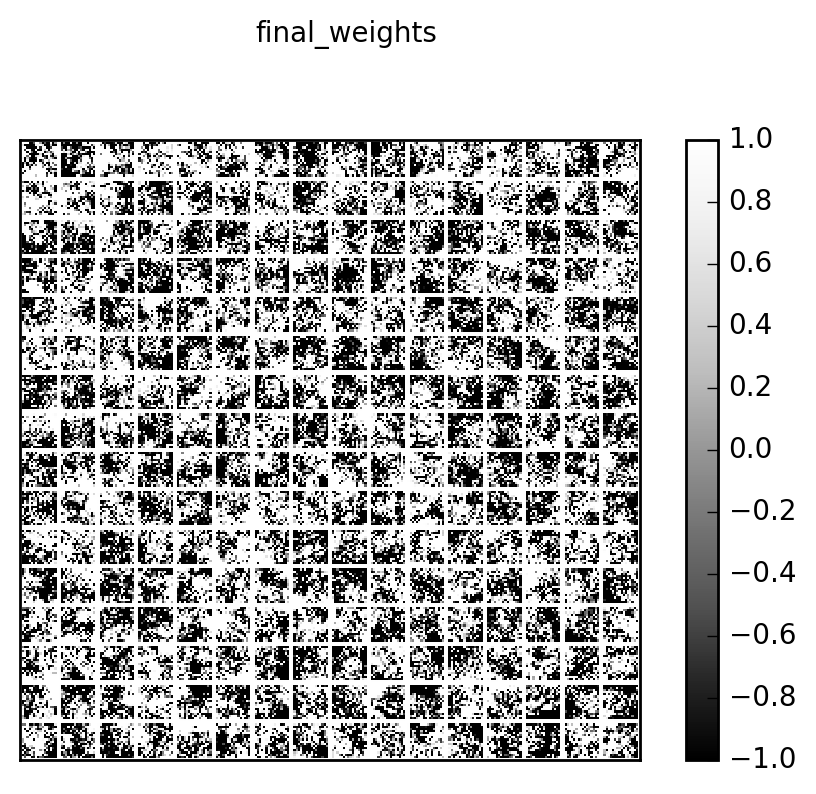

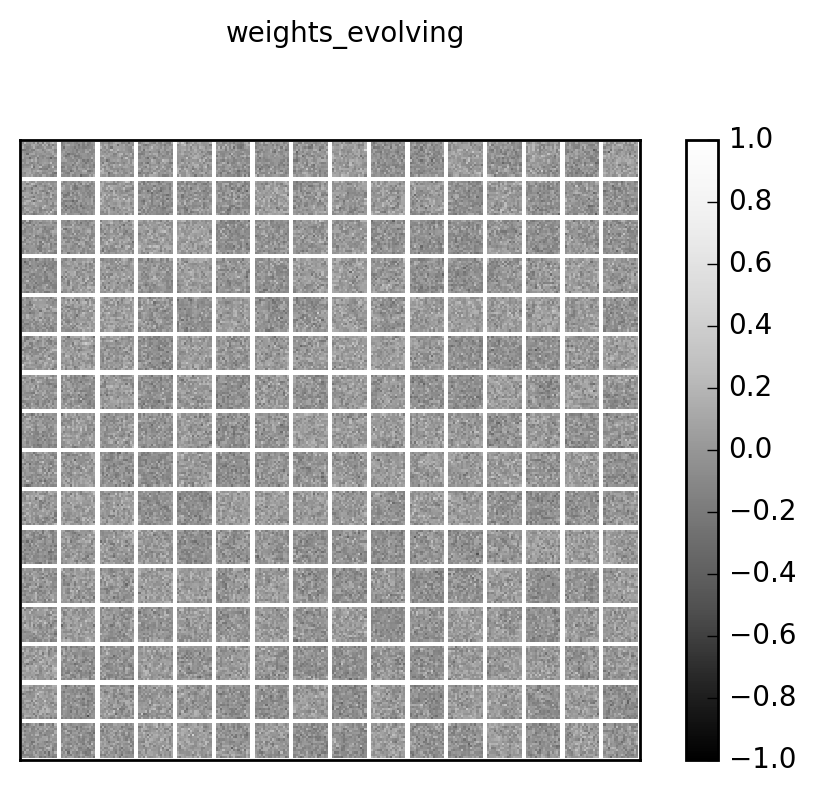

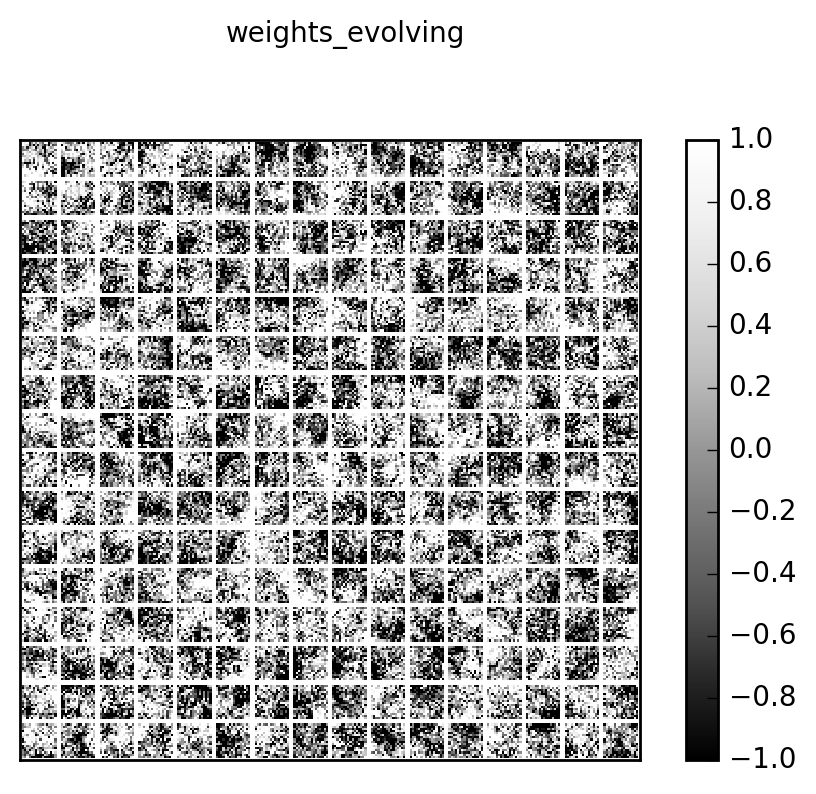

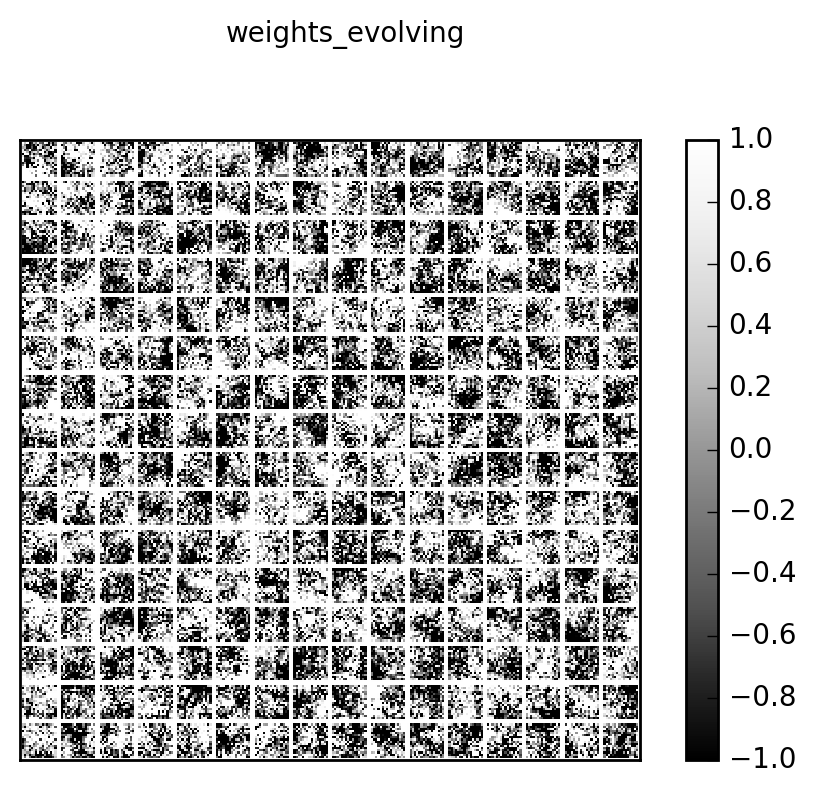

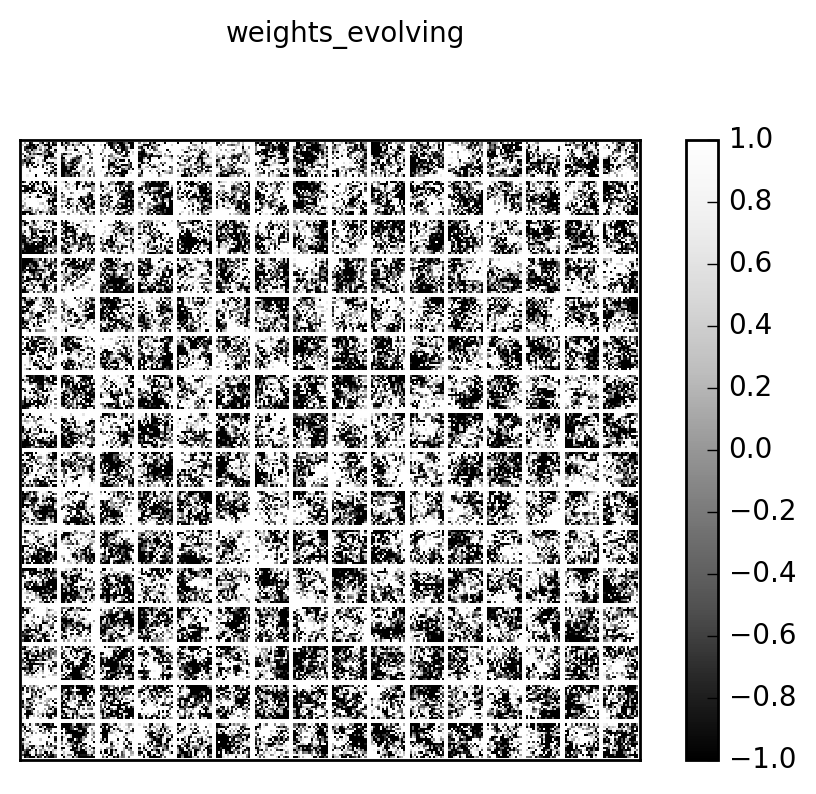

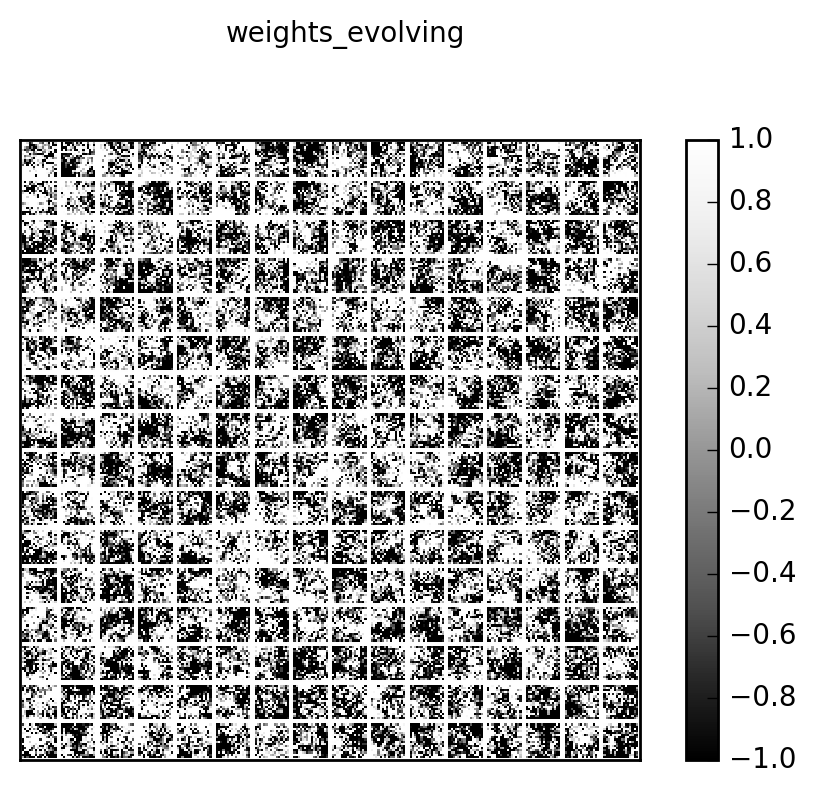

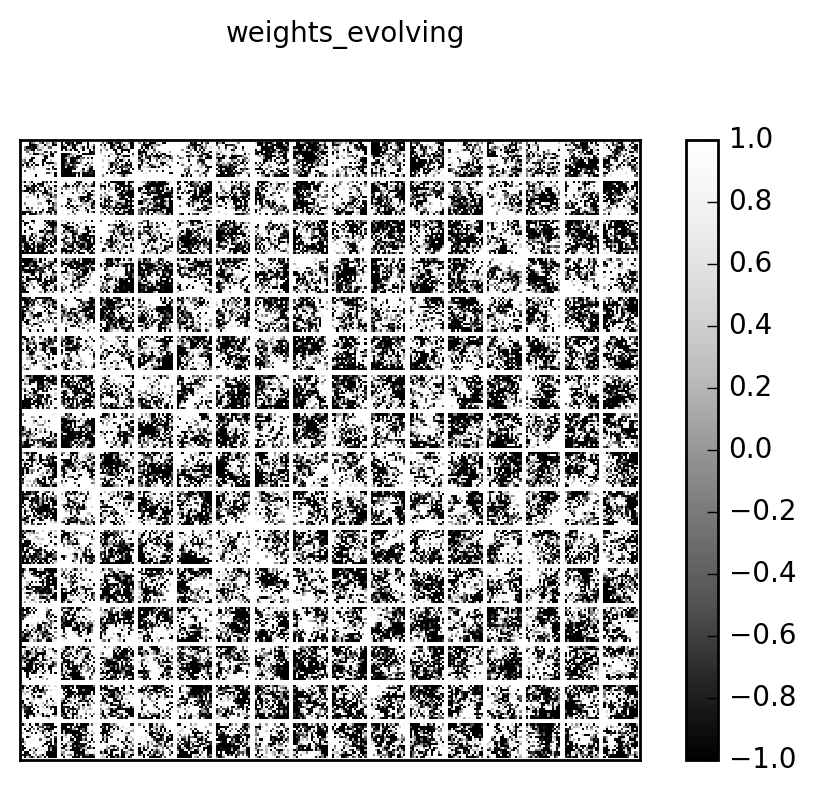

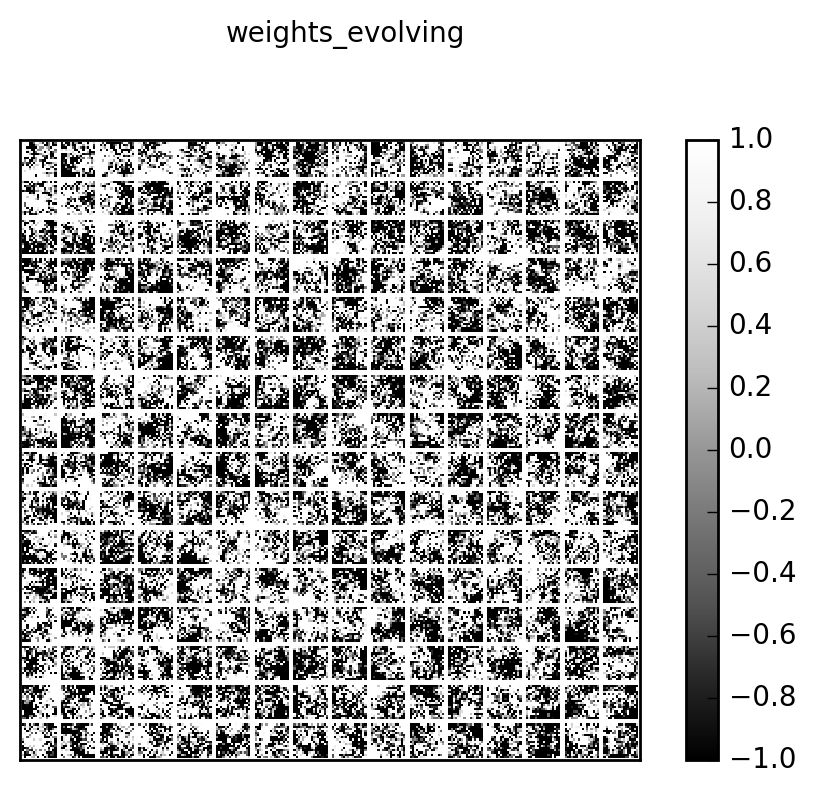

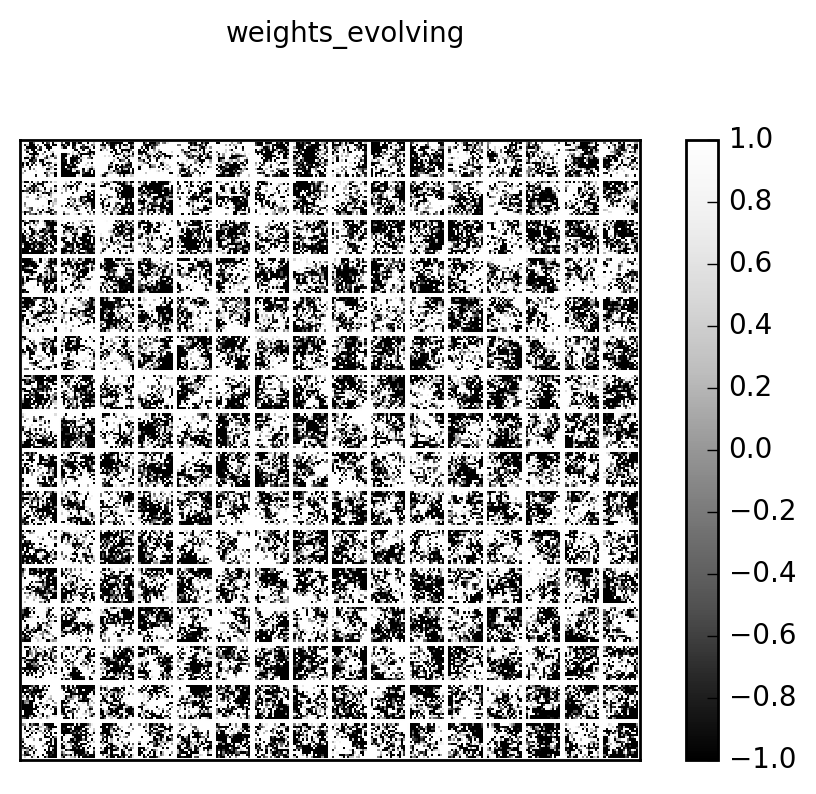

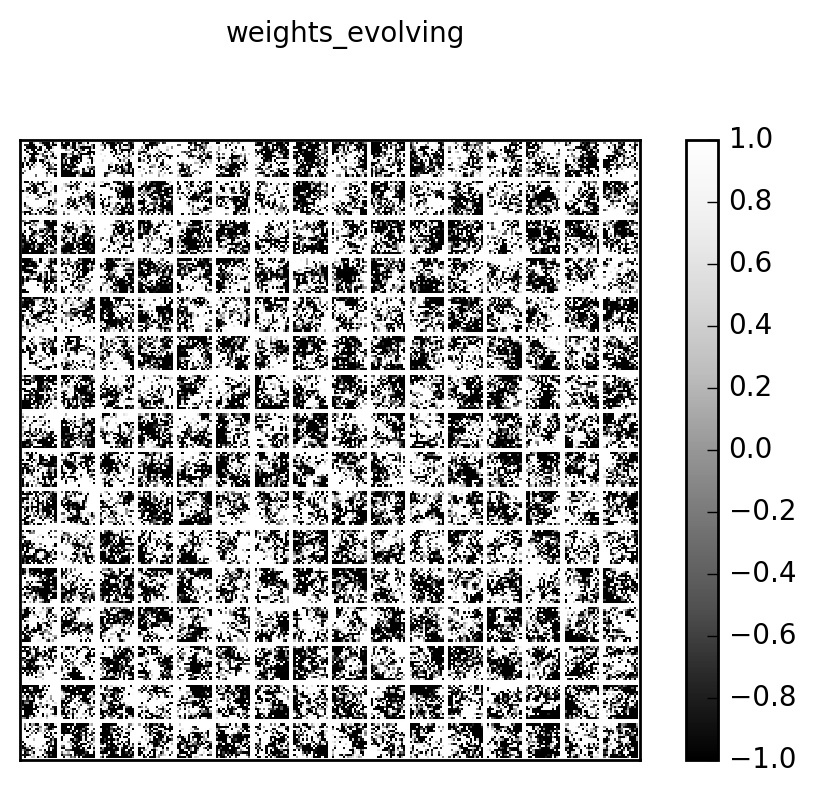

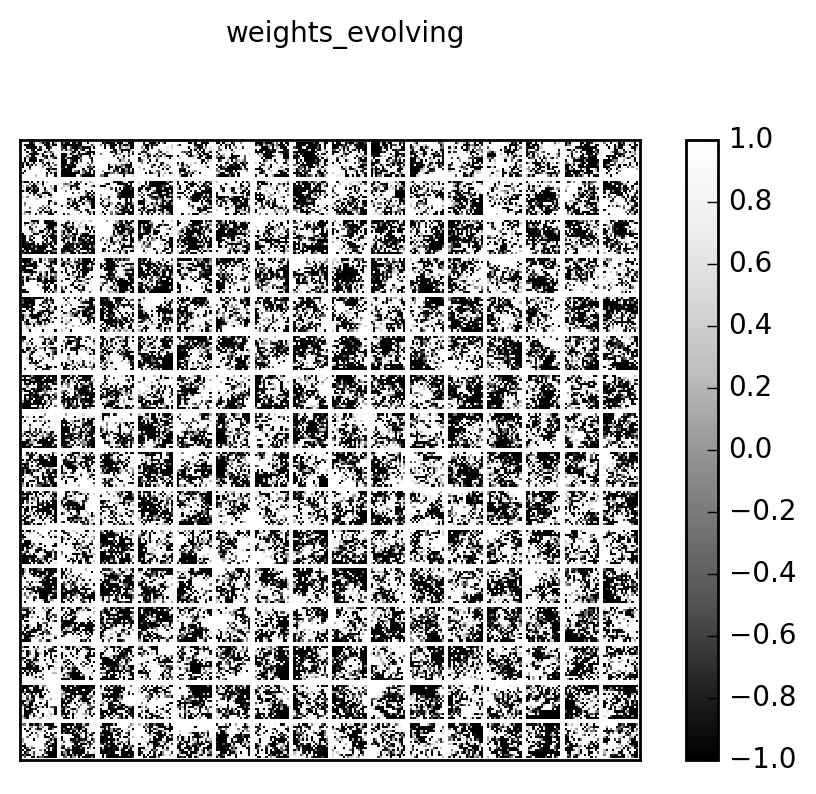

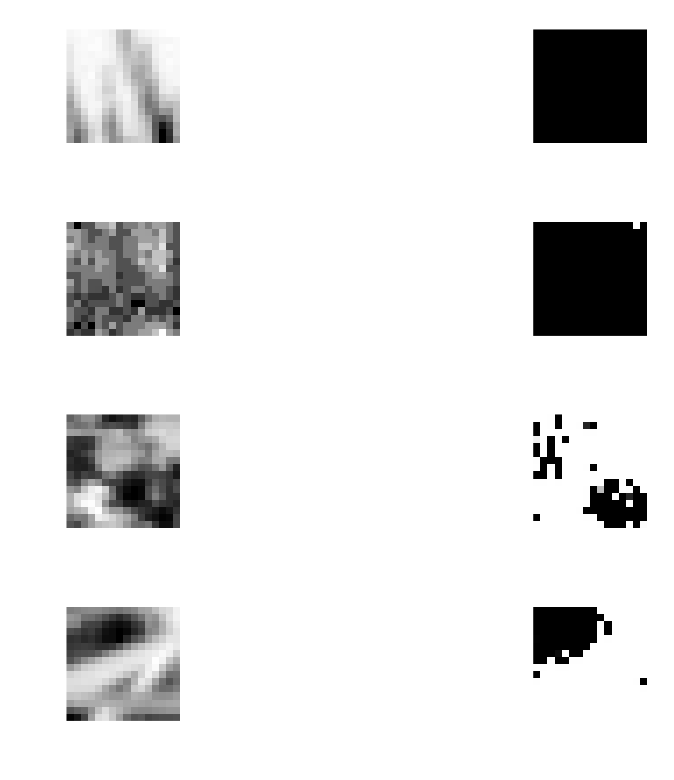

In [86]:
#run our param sweep
for compression in compressions:
    params['compression'] = compression
    #graph = make_graph(imxlen, imylen, compression)
    for model_type in models:
        params['model_type'] = model_type
        for batchsize in batchsizes:
            params['batchsize'] = batchsize
            for learning_rate in learning_rates:
                params['learning_rate'] = learning_rate
                for lambd in lambdas:
                    params['lambd'] = lambd
                    for nx in noise_xs:
                        params['noise_x'] = nx
                        for nr in noise_rs:
                            params['noise_r'] = nr

                            #make our model
                            aec = aec_model(params)
                            #train it
                            [cost_evolution,
                             wmean_evolution,
                             weights_evolution,
                             images,
                             recons,
                             final_weights] = train_model(aec)

                            save_plots(aec,
                                        cost_evolution,
                                        wmean_evolution,
                                        weights_evolution,
                                        images,
                                        recons,
                                        final_weights)

              

## Tensorboard Analysis

In [ ]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [ ]:
#show_graph(tf.get_default_graph().as_graph_def())

In [ ]:
def checknims(batchsize,iterations):
    nimstrained = batchsize * iterations
    if(nimstrained > nimages):
        print('ERROR! Trying to train',nimstrained,'images, but we only have',nimages,'images!')
    else:
        print('Training',nimstrained,'out of',nimages,'total image patches.')
